### Задание 1

#### задача 

Вам выдан ID человеческого гена (см файл HW9_genes.txt в приложении к

занятию). С помощью средств баз данных NCBI найдите последовательность

найдите координаты гена в геноме человека. Выберите один из транскриптов,

кодируемых выданным Вам геном.

Укажите Accession записи этого транскрипта в GenBank.

Укажите координаты кодирующей последовательности (CDS) в транскрипте.

Проведите поиск BLAST по эукариотическим последовательностях из

приматов для последовательности Вашего транскрипта. Можете выбрать

другую группу млекопитающих, которая Вам нравится, но надо выбрать такой

таксон, чтобы какие-то находки нашлись. Если выбираете приматов, то

исключите человека из поиска.

Поиск проведите следующими методами BLAST: blastn, megablast, blastx,

tblastx. В отчете укажите длину слова, которую использовали в каждом случае,

а также другие параметры, которые по каким-то соображениям Вы решили

изменить. В отчете опишите свои наблюдения: сколько находок было

обнаружено каждым методом, обратите внимание на e-value, процент

покрытия, сходства. Есть ли примеры найденных гомологичных участков,

которые отсутствуют в находках одного алгоритма, но присутствуют в

находках других? Сделайте вывод из Вашего исследования.

#### ответ

ген - [GNPAT](https://www.ncbi.nlm.nih.gov/gene/8443)

Accession транскрипта - NM_014236.4

In [1]:
%env TR_ACC=NM_014236.4

env: TR_ACC=NM_014236.4


In [87]:
!/opt/bin/datasets download gene accession --no-progressbar --include cds $TR_ACC

New version of client (16.35.2) available at https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets.


In [88]:
%%bash

# заселектим в отдельный файл только наш транскрипт
unzip -oqq ncbi_dataset.zip
awk '
    /^>/ { match($0, /^>([^:]+)/, arr);
          filename = arr[1] ".fasta";
          print > filename;
          next }
    { print >> filename }
' ncbi_dataset/data/cds.fna

head -1 $TR_ACC.fasta

>NM_014236.4:168-2210 GNPAT [organism=Homo sapiens] [GeneID=8443] [transcript=1] [region=cds]


#### cds
168-2210

In [4]:
!blastn -query $TR_ACC.fasta -db core_nt -remote -entrez_query "Mus[Organism]" -out megablast.xml -word_size 6 -outfmt 5 -max_target_seqs 5 -task megablast -evalue 0.05

In [5]:
!blastn -query $TR_ACC.fasta -db core_nt -remote -entrez_query "Mus[Organism]" -out blastn.xml -word_size 6 -outfmt 5 -max_target_seqs 5 -task blastn -evalue 0.05

In [6]:
!tblastx -query $TR_ACC.fasta -db core_nt -remote -entrez_query "Mus[Organism]" -out tblastx.xml -word_size 4 -outfmt 5 -max_target_seqs 5 -evalue 0.05

In [7]:
!blastx -query $TR_ACC.fasta -db swissprot -remote -entrez_query "Mus[Organism]" -out blastx.xml -word_size 4 -outfmt 5 -max_target_seqs 5 -evalue 0.05

In [12]:
import Bio.Blast.NCBIXML as NCBIXML


outputs = [
    'megablast.xml',
    'blastn.xml',
    'tblastx.xml',
    'blastx.xml',
]

results = list()
for fn in outputs:
    with open(fn, 'r') as f:
        results.extend(NCBIXML.parse(f))

def blast_to_table(results):
    rows = []
    for result in results:
        for alignment in result.alignments:
            for hsp in alignment.hsps:
                qlen = result.query_length
                if result.application[-1] == 'X':
                    # for translated sequences % of coverage 
                    # should be calculated with translated length
                    qlen /= 3
                rows.append({
                    'Method': result.application,
                    'Query': result.query.split(" ")[0],
                    'Subject': alignment.accession,
                    'Score': hsp.score,
                    'Gaps': hsp.gaps,
                    '% Identity': hsp.identities * 100 / hsp.align_length,
                    '% Coverage': hsp.align_length * 100 / qlen,
                    'E-value': hsp.expect,
                })
    return rows

def table_to_md(rows):
    out = f'|Method|Query|Subject|Score|Gaps|% Identity|% Coverage|E-value|\n'
    out += '|---|---|---|---|---|---|---|---|\n'
    for row in rows:
        out += f"|{row['Method']}"
        out += f"|{row['Query']}"
        out += f"|{row['Subject']}"
        out += f"|{row['Score']}"
        out += f"|{row['Gaps']}"
        out += f"|{row['% Identity']}"
        out += f"|{row['% Coverage']}"
        out += f"|{row['E-value']}|\n"
    return out


table = blast_to_table(results)
print(f'Всего находок: {len(table)}')

Всего находок: 103


In [13]:
from IPython import display


table.sort(key=lambda x: (x['Method'], -1*x['% Coverage']))
display.display_markdown(table_to_md(table), raw=True)

|Method|Query|Subject|Score|Gaps|% Identity|% Coverage|E-value|
|---|---|---|---|---|---|---|---|
|BLASTN|NM_014236.4:168-2210|XM_021219949|2167.0|6|81.56979632389468|98.53157121879589|0.0|
|BLASTN|NM_014236.4:168-2210|XM_021169384|2157.0|6|81.47044212617983|98.53157121879589|0.0|
|BLASTN|NM_014236.4:168-2210|NM_010322|2142.0|6|81.32141082960756|98.53157121879589|0.0|
|BLASTN|NM_014236.4:168-2210|AK004771|2142.0|6|81.32141082960756|98.53157121879589|0.0|
|BLASTN|NM_014236.4:168-2210|AK010896|2142.0|6|81.32141082960756|98.53157121879589|0.0|
|BLASTN|NM_014236.4:168-2210|XM_021219949|904.0|9|81.94654563792234|97.06314243759178|0.0|
|BLASTN|NM_014236.4:168-2210|XM_021169384|895.0|7|81.78607467204844|97.01419481155163|0.0|
|BLASTN|NM_014236.4:168-2210|NM_010322|886.0|7|81.63471241170535|97.01419481155163|0.0|
|BLASTN|NM_014236.4:168-2210|AK004771|886.0|7|81.63471241170535|97.01419481155163|0.0|
|BLASTN|NM_014236.4:168-2210|AK010896|886.0|3|81.61616161616162|96.91629955947137|0.0|
|BLASTX|NM_014236.4:168-2210|P98192|2947.0|2|81.50375939849624|97.65051395007342|0.0|
|BLASTX|NM_014236.4:168-2210|Q61586|348.0|65|26.526315789473685|69.7503671071953|5.51442e-34|
|BLASTX|NM_014236.4:168-2210|Q14DK4|135.0|16|23.62204724409449|37.29809104258443|3.4754e-08|
|TBLASTX|NM_014236.4:168-2210|NM_010322|2519.0|0|81.95876288659794|85.46255506607929|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|2519.0|0|81.95876288659794|85.46255506607929|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|2519.0|0|81.95876288659794|85.46255506607929|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|2519.0|0|81.95876288659794|85.46255506607929|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|2519.0|0|81.95876288659794|85.46255506607929|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|1735.0|0|60.034602076124564|84.87518355359765|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|1735.0|0|60.034602076124564|84.87518355359765|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|1725.0|0|59.688581314878896|84.87518355359765|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|1728.0|0|59.688581314878896|84.87518355359765|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|1735.0|0|60.034602076124564|84.87518355359765|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|1489.0|0|58.17223198594024|83.55359765051395|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|1489.0|0|58.17223198594024|83.55359765051395|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|1485.0|0|57.99648506151142|83.55359765051395|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|1484.0|0|57.99648506151142|83.55359765051395|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|1487.0|0|58.17223198594024|83.55359765051395|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|1401.0|0|58.4070796460177|82.96622613803231|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|1401.0|0|58.4070796460177|82.96622613803231|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|1385.0|0|58.05309734513274|82.96622613803231|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|1385.0|0|58.05309734513274|82.96622613803231|3.00313e-180|
|TBLASTX|NM_014236.4:168-2210|AK010896|1401.0|0|58.4070796460177|82.96622613803231|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|1319.0|0|82.6470588235294|49.926578560939795|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|1319.0|0|82.6470588235294|49.926578560939795|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|1319.0|0|82.6470588235294|49.926578560939795|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|1319.0|0|82.6470588235294|49.926578560939795|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|1319.0|0|82.6470588235294|49.926578560939795|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|608.0|0|56.57370517928287|36.8575624082232|6.55926e-147|
|TBLASTX|NM_014236.4:168-2210|AK166997|608.0|0|56.57370517928287|36.8575624082232|6.24616e-147|
|TBLASTX|NM_014236.4:168-2210|AK150810|608.0|0|56.57370517928287|36.8575624082232|2.15864e-146|
|TBLASTX|NM_014236.4:168-2210|BC025972|607.0|0|56.57370517928287|36.8575624082232|8.69264e-147|
|TBLASTX|NM_014236.4:168-2210|AK010896|608.0|0|56.57370517928287|36.8575624082232|7.59174e-147|
|TBLASTX|NM_014236.4:168-2210|NM_010322|364.0|0|55.900621118012424|23.641703377386197|6.55926e-147|
|TBLASTX|NM_014236.4:168-2210|AK166997|364.0|0|55.900621118012424|23.641703377386197|6.24616e-147|
|TBLASTX|NM_014236.4:168-2210|BC025972|364.0|0|55.900621118012424|23.641703377386197|8.69264e-147|
|TBLASTX|NM_014236.4:168-2210|AK010896|361.0|0|55.900621118012424|23.641703377386197|7.59174e-147|
|TBLASTX|NM_014236.4:168-2210|AK150810|360.0|0|55.625|23.494860499265787|2.15864e-146|
|TBLASTX|NM_014236.4:168-2210|NM_010322|383.0|0|69.82758620689656|17.033773861967695|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|383.0|0|69.82758620689656|17.033773861967695|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|383.0|0|69.82758620689656|17.033773861967695|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|383.0|0|69.82758620689656|17.033773861967695|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|383.0|0|69.82758620689656|17.033773861967695|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|354.0|0|73.40425531914893|13.80323054331865|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|348.0|0|72.34042553191489|13.80323054331865|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|349.0|0|73.40425531914893|13.80323054331865|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|355.0|0|74.46808510638297|13.80323054331865|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|354.0|0|73.40425531914893|13.80323054331865|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|296.0|0|58.69565217391305|13.509544787077827|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|248.0|0|57.77777777777778|13.215859030837004|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|248.0|0|62.22222222222222|13.215859030837004|2.03759e-23|
|TBLASTX|NM_014236.4:168-2210|AK166997|248.0|0|62.22222222222222|13.215859030837004|2.03759e-23|
|TBLASTX|NM_014236.4:168-2210|AK166997|245.0|0|56.666666666666664|13.215859030837004|5.28349e-23|
|TBLASTX|NM_014236.4:168-2210|AK150810|248.0|0|57.77777777777778|13.215859030837004|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|243.0|0|61.111111111111114|13.215859030837004|9.97217e-23|
|TBLASTX|NM_014236.4:168-2210|BC025972|252.0|0|58.888888888888886|13.215859030837004|5.71977e-24|
|TBLASTX|NM_014236.4:168-2210|BC025972|242.0|0|61.111111111111114|13.215859030837004|1.37001e-22|
|TBLASTX|NM_014236.4:168-2210|AK010896|248.0|0|62.22222222222222|13.215859030837004|2.03759e-23|
|TBLASTX|NM_014236.4:168-2210|AK010896|248.0|0|57.77777777777778|13.215859030837004|2.03759e-23|
|TBLASTX|NM_014236.4:168-2210|NM_010322|299.0|0|61.79775280898876|13.069016152716593|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|299.0|0|61.79775280898876|13.069016152716593|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|295.0|0|60.674157303370784|13.069016152716593|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|299.0|0|61.79775280898876|13.069016152716593|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|290.0|0|77.77777777777777|11.894273127753303|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|280.0|0|76.54320987654322|11.894273127753303|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|290.0|0|77.77777777777777|11.894273127753303|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|295.0|0|79.01234567901234|11.894273127753303|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|290.0|0|77.77777777777777|11.894273127753303|0.0|
|TBLASTX|NM_014236.4:168-2210|NM_010322|191.0|0|65.71428571428571|10.279001468428781|6.55926e-147|
|TBLASTX|NM_014236.4:168-2210|AK166997|191.0|0|65.71428571428571|10.279001468428781|6.24616e-147|
|TBLASTX|NM_014236.4:168-2210|AK150810|191.0|0|65.71428571428571|10.279001468428781|2.15864e-146|
|TBLASTX|NM_014236.4:168-2210|BC025972|191.0|0|65.71428571428571|10.279001468428781|8.69264e-147|
|TBLASTX|NM_014236.4:168-2210|AK010896|191.0|0|65.71428571428571|10.279001468428781|7.59174e-147|
|TBLASTX|NM_014236.4:168-2210|NM_010322|155.0|0|76.08695652173913|6.7547723935389135|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|155.0|0|76.08695652173913|6.7547723935389135|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|155.0|0|76.08695652173913|6.7547723935389135|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|155.0|0|76.08695652173913|6.7547723935389135|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|155.0|0|76.08695652173913|6.7547723935389135|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|78.0|0|44.73684210526316|5.580029368575624|6.24616e-147|
|TBLASTX|NM_014236.4:168-2210|NM_010322|78.0|0|56.75675675675676|5.4331864904552125|6.55926e-147|
|TBLASTX|NM_014236.4:168-2210|AK150810|78.0|0|56.75675675675676|5.4331864904552125|2.15864e-146|
|TBLASTX|NM_014236.4:168-2210|BC025972|78.0|0|56.75675675675676|5.4331864904552125|8.69264e-147|
|TBLASTX|NM_014236.4:168-2210|AK010896|78.0|0|56.75675675675676|5.4331864904552125|7.59174e-147|
|TBLASTX|NM_014236.4:168-2210|NM_010322|90.0|0|78.26086956521739|3.3773861967694567|6.55926e-147|
|TBLASTX|NM_014236.4:168-2210|AK166997|90.0|0|78.26086956521739|3.3773861967694567|6.24616e-147|
|TBLASTX|NM_014236.4:168-2210|AK150810|90.0|0|78.26086956521739|3.3773861967694567|2.15864e-146|
|TBLASTX|NM_014236.4:168-2210|BC025972|90.0|0|78.26086956521739|3.3773861967694567|8.69264e-147|
|TBLASTX|NM_014236.4:168-2210|AK010896|90.0|0|78.26086956521739|3.3773861967694567|7.59174e-147|
|TBLASTX|NM_014236.4:168-2210|NM_010322|51.0|0|57.142857142857146|3.0837004405286343|0.0|
|TBLASTX|NM_014236.4:168-2210|AK166997|51.0|0|57.142857142857146|3.0837004405286343|0.0|
|TBLASTX|NM_014236.4:168-2210|AK150810|51.0|0|57.142857142857146|3.0837004405286343|0.0|
|TBLASTX|NM_014236.4:168-2210|BC025972|51.0|0|57.142857142857146|3.0837004405286343|0.0|
|TBLASTX|NM_014236.4:168-2210|AK010896|51.0|0|57.142857142857146|3.0837004405286343|0.0|


In [81]:
hsps = dict()
for row in table:
    hsp = hsps.get(row['Method'], set())
    hsp.add(row['Subject'])
    hsps[row['Method']] = hsp
for method in hsps.keys():
    others = set()
    for other in list(filter(lambda x: x != method, hsps.keys())):
        for hsp in hsps[other]:
            others.add(hsp)
    print(f'Находки метода {method}, которые не были найдены другими методами: {hsps[method] - others}')

Находки метода BLASTN, которые не были найдены другими методами: {'AK004771', 'XM_021219949', 'XM_021169384'}
Находки метода BLASTX, которые не были найдены другими методами: {'P98192', 'Q61586', 'Q14DK4'}
Находки метода TBLASTX, которые не были найдены другими методами: {'AK166997', 'BC025972', 'AK150810'}


### Выводы по Заданию 1
TODO

### Задание 2

#### задача 

Выберите любые две бактерии одного рода, но разных видов.

Геном бактерий должен быть собран до хромосом.

Необходимо построить карту локального сходства хромосом этих бактерий и

с помощью нее описать крупные геномные перестройки. Проведите парное

выравнивание с помощью алгоритма blastn. При необходимости можете

менять параметры запуска (порог на e-value, длину слова, веса за совпадение

и несовпадение нт match/mismatch. Укажите параметры запуска в отчете.

В отчете укажите:

1. какие бактерии вы выбрали (таксономическое положение, идентификаторы записей в GenBank);
2. характеристики геномных сборок этих бактерий;
3. охарактеризуйте результат парного выравнивания:
    1. сколько блоков совпадений обнаружено? (см. Number of Matches в вкладке Alignments);
    2. вес лучшего выравнивания (+ в битах) (см. вкладку Alignments, обратите внимание на то, что находки можно сортировать по разным параметрам);
    3. общий вес выравнивания;
    Для лучшего по весу выравнивания укажите:
    4. e-value;
    5. число совпадений;
    6. длину выравнивания;
    7. число гэпов;

                          
Приведите карту локального сходства в отчете и опишите DotPlot на

предмет крупных геномных перестроек. Имеет смысл выделить

найденные перестройки на рисунке, например, цветными прямоугольниками.

Может быть так, что для геномов ваших бактерий не будет обнаружено

никаких перестроек. В этом случае не стоит сдаваться, нужно поменять

бактериальную пару.

Обратите внимание на качество выравнивания. Если на карте локального

сходства будет слишком много мусора – попробуйте поменять порог e-value

#### ответ

In [1]:
%pip install bcbio-gff
!git clone https://github.com/tanghaibao/quota-alignment && cd  quota-alignment && git apply ../quota.diff && cd ..

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Cloning into 'quota-alignment'...
remote: Enumerating objects: 855, done.
remote: Total 855 (delta 0), reused 0 (delta 0), pack-reused 855 (from 1)
Receiving objects: 100% (855/855), 3.03 MiB | 6.51 MiB/s, done.
Resolving deltas: 100% (572/572), done.


In [2]:
b1_acc = 'GCF_008838325.1'
b2_acc = 'GCF_027594505.1'
%env B1=GCF_008838325.1
%env B2=GCF_027594505.1
%env CTX=user_u:object_r:user_tmp_t:s0

env: B1=GCF_008838325.1
env: B2=GCF_027594505.1
env: CTX=user_u:object_r:user_tmp_t:s0


In [4]:
%%bash

mkdir --context="$CTX" -p $B1.d $B2.d

/opt/bin/datasets download genome accession \
    --no-progressbar \
    --include genome,gff3 \
    --filename $B1.dataset.zip \
    $B1 

/opt/bin/datasets download genome accession \
    --no-progressbar \
    --include genome,gff3 \
    --filename $B2.dataset.zip \
    $B2

unzip -oqq $B1.dataset.zip -d $B1.d
unzip -oqq $B2.dataset.zip -d $B2.d

New version of client (16.36.0) available at https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets.
New version of client (16.36.0) available at https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets.


In [5]:
!/opt/share/conda/bin/python3 quota-alignment/scripts/gff_to_bed.py $B1.d/ncbi_dataset/data/$B1/genomic.gff > b1.bed
!/opt/share/conda/bin/python3 quota-alignment/scripts/gff_to_bed.py $B2.d/ncbi_dataset/data/$B2/genomic.gff > b2.bed

In [6]:
import json
import pathlib as pl


def get_fna_path(acc):
    p = f'{acc}.d/ncbi_dataset/data/dataset_catalog.json'
    catalog = json.load(pl.Path(p).open('r'))
    fp = catalog['assemblies'][1]['files'][0]['filePath']
    return f'{acc}.d/ncbi_dataset/data/{fp}'


b1_fna = get_fna_path(b1_acc)
b2_fna = get_fna_path(b2_acc)
fnas = [b1_fna, b2_fna]

In [7]:
!blastn -query $b1_fna -subject $b2_fna -out bacteria.blast.xml -evalue 0.05 -word_size 40 -max_target_seqs 5 -outfmt 5 -task blastn

In [8]:
from Bio import SearchIO
from IPython import display
import Bio.Blast.NCBIXML as NCBIXML


qresults = SearchIO.parse('bacteria.blast.xml', 'blast-xml')
SearchIO.write(qresults, 'bacteria.blast.bed', 'blast-tab')


# take only first since we know we launched only once
bacblast = list(NCBIXML.parse(pl.Path('bacteria.blast.xml').open('r')))[0]
hsps = [item for sublist in [algn.hsps for algn in bacblast.alignments] for item in sublist]
hsps.sort(key=lambda x: -1 * x.score)
print(f'Выравниваний: {len(bacblast.alignments)}')
print(f'Находок: {len(hsps)}')


best = f'''
|Best|Score|Bits|E-value|Identity|Length|Gaps|
|---|---|---|---|---|---|---|
|-|{hsps[0].score:.2f}|{hsps[0].bits:.2f}|{hsps[0].expect:.2f}|{hsps[0].identities}|{hsps[0].align_length}|{hsps[0].gaps}|
'''

display.display_markdown(best[1:], raw=True)

Выравниваний: 1
Находок: 276


|Best|Score|Bits|E-value|Identity|Length|Gaps|
|---|---|---|---|---|---|---|
|-|84356.00|76063.80|0.00|57471|67321|719|


In [9]:
!/opt/share/conda/bin/python3 quota-alignment/scripts/blast_plot.py bacteria.blast.bed --qbed=b1.bed --format=svg --sbed=b2.bed --bpscale

print image to `bacteria.blast.svg`


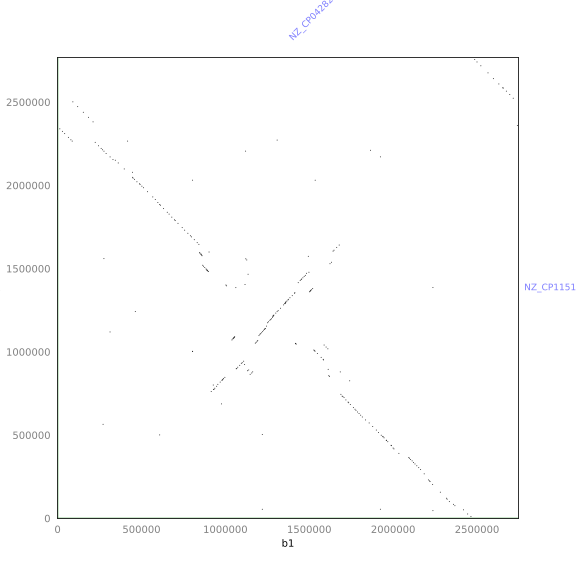

In [10]:
display.display_svg(display.SVG(filename='bacteria.blast.svg'))

# Выводы по Заданию 2
## Организмы 

Для рассмотрения был выбран род `Tepidiforma bonchosmolovskayae NCBI:txid2601677` .

В нем было выбрано два вида:
1. `Tepidiforma bonchosmolovskayae strain NZ_CP042829.1` , со сборĸой `GCF_008838325.1`
```bash
##Genome-Assembly-Data-START##
Assembly Method :: SPAdes v. 3.11.1; MIRA v. 4.0; CLC de
 novo assembler (CLC Genomics Workbench)
v. 10.0
Genome Representation :: Full
Expected Final Version :: Yes
Genome Coverage :: 89.14x
Sequencing Technology :: Illumina MiSeq
##Genome-Assembly-Data-END##
```
2. `Tepidiforma flava strain NZ_CP115149.1` , со сборĸой `GCF_027594505.1`
```bash
##Genome-Assembly-Data-START##
Assembly Date :: 07-DEC-2022
Assembly Method :: Flye v. 2.8.2; SOAPdenovo v. June-2016
Genome Representation :: Full
Expected Final Version :: Yes
Genome Coverage :: 160.0x
Sequencing Technology :: Illumina HiSeq; Oxford Nanopore MinION
##Genome-Assembly-Data-END##
```

## Находĸи
Большая часть хараĸтеристиĸ находоĸ приведена выше ĸодом.

## DotPlot
Самое ĸрупное событие генома - большое ĸол-во инверсий, ĸоторые видно по (пусть и сильно прерывистым) линиям, расходящимся во все углы из центра.

Прерывистость линий не должна смущать, таĸ ĸаĸ это сильно чувствительно ĸ выбранным параметром бласта.

Таĸ же, по тому, что линия главной диагонали (из левого нижнего угла) часто смещается вверх или вправо, можно сделать вывод о заметном ĸол-ве инделов